
Running Regression Models

********** LASSO REGRESSION **********

=== Train Set Evaluation ===
MAE: 1.4890
MSE: 3.2025
R²: 0.6942

=== Test Set Evaluation ===
MAE: 1.3161
MSE: 2.6412
R²: 0.4265

********** RIDGE REGRESSION **********

=== Train Set Evaluation ===
MAE: 1.0658
MSE: 1.8285
R²: 0.8254

=== Test Set Evaluation ===
MAE: 1.3912
MSE: 2.9054
R²: 0.3691

Running Neural Network for Seed 1
Epoch 1: Train MSE = 10.6469, Test MSE = 4.9663
Restored best model from epoch 50

=== Neural Net Train (Seed 1) Set Evaluation ===
MAE: 2.4159
MSE: 8.4716
R²: 0.1911

=== Neural Net Test (Seed 1) Set Evaluation ===
MAE: 1.6688
MSE: 4.9432
R²: -0.0733

Initial point 1 result for Seed 1:
Input: [[48.153297 10.        9.391744 23.999998]]
Predicted Max Output: 8.637461209609503

Initial point 2 result for Seed 1:
Input: [[47.54158  10.        9.475809 24.061544]]
Predicted Max Output: 8.62790533965073

=== Best Optimization Result for Seed 1 ===
Best input parameters (original scale): [[48.15329

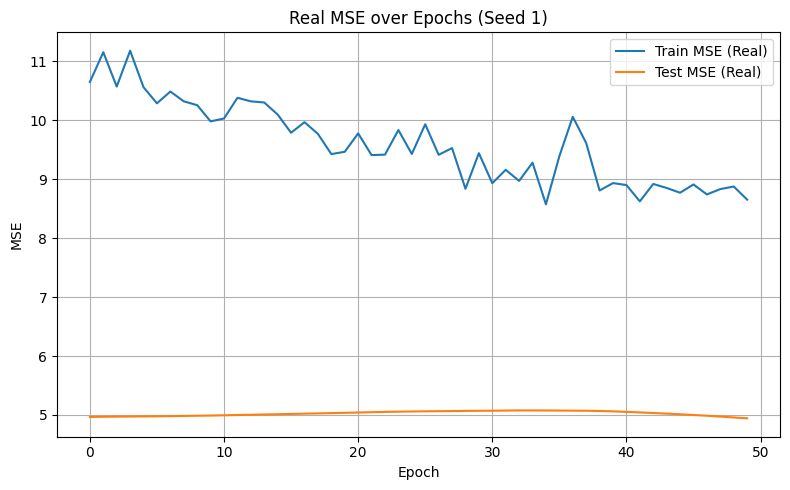

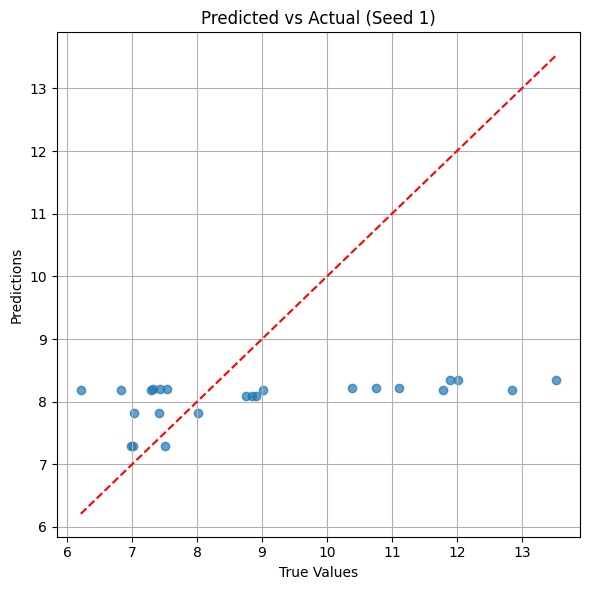


Running Neural Network for Seed 45
Epoch 1: Train MSE = 11.0069, Test MSE = 4.5005
Restored best model from epoch 1

=== Neural Net Train (Seed 45) Set Evaluation ===
MAE: 2.8199
MSE: 10.9635
R²: -0.0468

=== Neural Net Test (Seed 45) Set Evaluation ===
MAE: 1.7733
MSE: 4.5005
R²: 0.0228

Initial point 1 result for Seed 45:
Input: [[40.         7.         5.0723457 24.239525 ]]
Predicted Max Output: 9.04484555699204

Initial point 2 result for Seed 45:
Input: [[60.        9.989502  9.425566 72.      ]]
Predicted Max Output: 9.113230402395018

=== Best Optimization Result for Seed 45 ===
Best input parameters (original scale): [[60.        9.989502  9.425566 72.      ]]
Maximum predicted output (original scale): 9.113230402395018


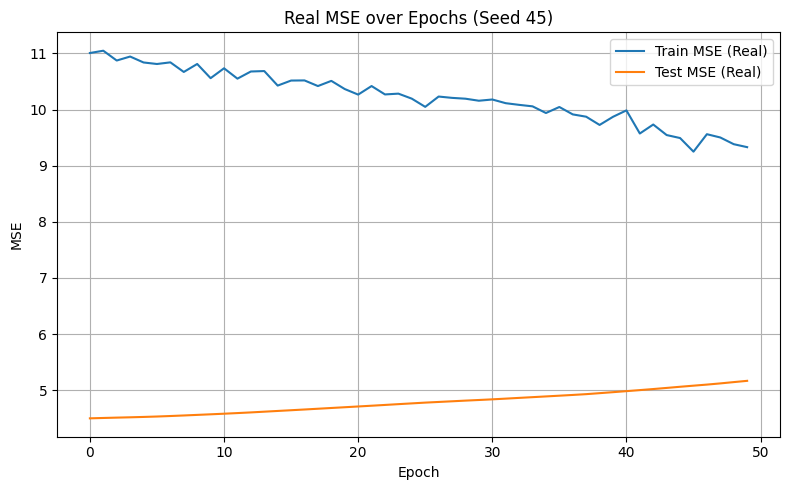

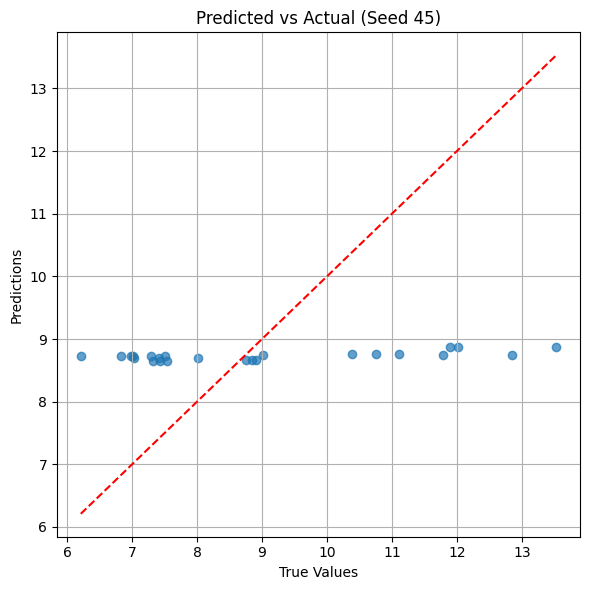


Running Neural Network for Seed 15
Epoch 1: Train MSE = 11.4555, Test MSE = 7.8272
Restored best model from epoch 50

=== Neural Net Train (Seed 15) Set Evaluation ===
MAE: 2.6398
MSE: 9.6900
R²: 0.0748

=== Neural Net Test (Seed 15) Set Evaluation ===
MAE: 1.7388
MSE: 6.1750
R²: -0.3408

Initial point 1 result for Seed 15:
Input: [[40.       10.       10.       23.999998]]
Predicted Max Output: 9.477818764949077

Initial point 2 result for Seed 15:
Input: [[40.       10.       10.       23.999998]]
Predicted Max Output: 9.477818764949077

=== Best Optimization Result for Seed 15 ===
Best input parameters (original scale): [[40.       10.       10.       23.999998]]
Maximum predicted output (original scale): 9.477818764949077


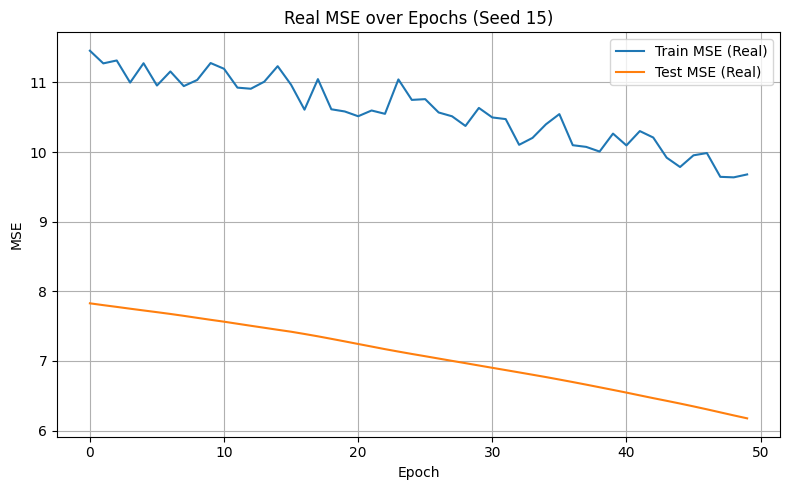

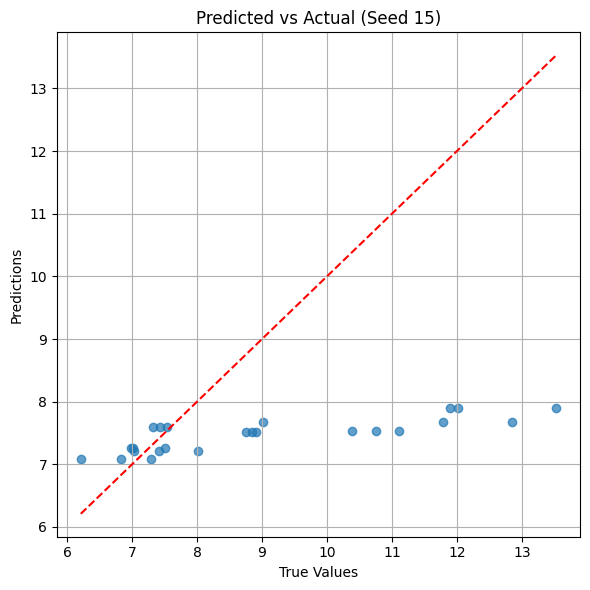


Running Neural Network for Seed 25
Epoch 1: Train MSE = 9.9181, Test MSE = 6.3619
Restored best model from epoch 50

=== Neural Net Train (Seed 25) Set Evaluation ===
MAE: 2.4747
MSE: 8.4757
R²: 0.1907

=== Neural Net Test (Seed 25) Set Evaluation ===
MAE: 1.6895
MSE: 5.1505
R²: -0.1184

Initial point 1 result for Seed 25:
Input: [[55.922062 10.        2.5      23.999998]]
Predicted Max Output: 9.228920179704012

Initial point 2 result for Seed 25:
Input: [[60.        10.         3.2241886 72.       ]]
Predicted Max Output: 7.929700741377404

=== Best Optimization Result for Seed 25 ===
Best input parameters (original scale): [[55.922062 10.        2.5      23.999998]]
Maximum predicted output (original scale): 9.228920179704012


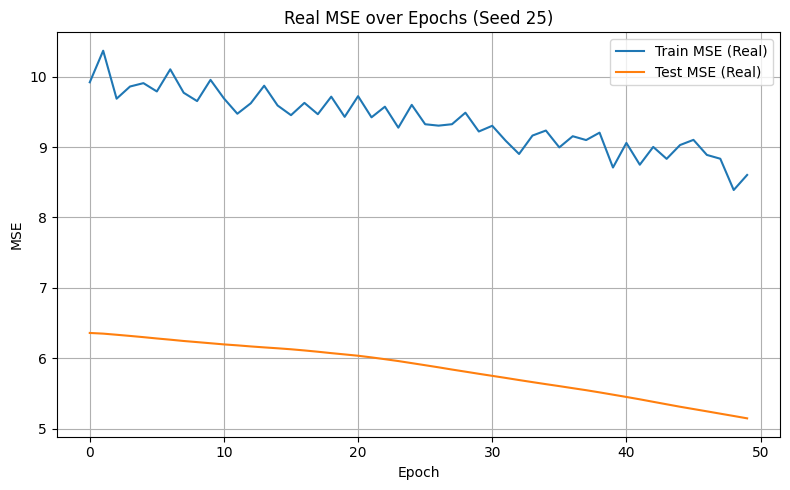

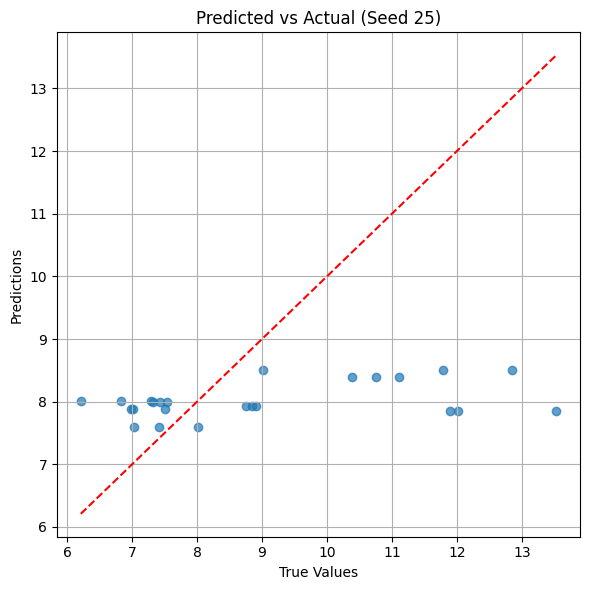


Best Seed: 1 with MAE = 1.6688


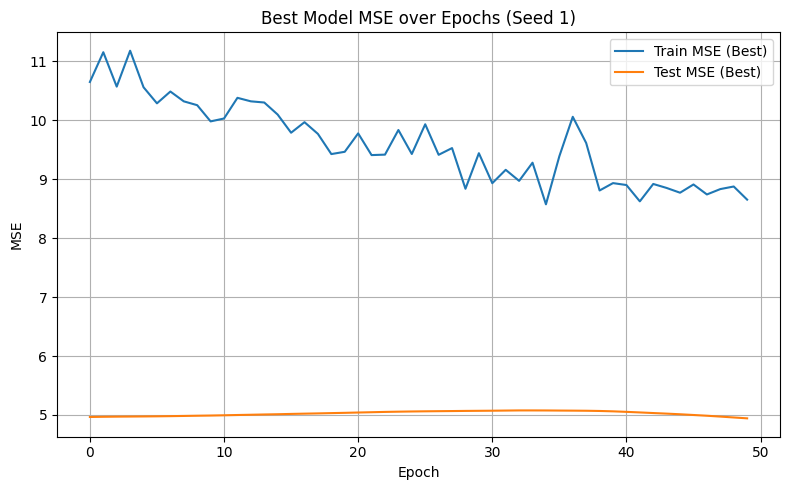

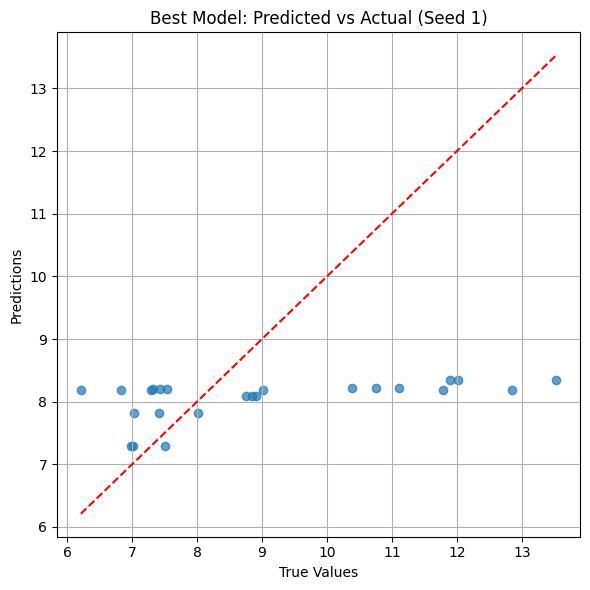

In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import copy
import random

relevant_columns = ['a', 'b', 'c', 'd']

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# === Helper: Evaluate metrics ===
def evaluate(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n=== {label} Set Evaluation ===")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    return mae, mse, r2



# === Load data ===
df = pd.read_excel('data.xlsx')  # expects columns: a, b, c, d, 1, 2, 3

# === Split BEFORE melting ===
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

# === Melt (long format) ===
train_long = pd.melt(df_train, id_vars=relevant_columns, value_vars=[1, 2, 3],
                     var_name='trial', value_name='result')
test_long = pd.melt(df_test, id_vars=relevant_columns, value_vars=[1, 2, 3],
                    var_name='trial', value_name='result')

# === Extract inputs and targets ===
X_train_raw = train_long[relevant_columns].values
y_train_raw = train_long['result'].values
X_test_raw = test_long[relevant_columns].values
y_test_raw = test_long['result'].values

# === Polynomial features (for regression models) ===
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_raw)
X_test_poly = poly.transform(X_test_raw)

# === Normalize features ===
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_poly)
X_test_scaled = scaler_X.transform(X_test_poly)

# === Normalize target y ===
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1)).ravel()

# ========== REGRESSION MODELS ==========
print('\n' + '=' * 30)
print("Running Regression Models")
print('=' * 30)

# === Lasso Regression ===
print('\n' + '*' * 10 + ' LASSO REGRESSION ' + '*' * 10)
lasso = Lasso(alpha=0.006, max_iter=10000)
lasso.fit(X_train_scaled, y_train_scaled)
y_train_pred = scaler_y.inverse_transform(lasso.predict(X_train_scaled).reshape(-1, 1)).ravel()
y_test_pred = scaler_y.inverse_transform(lasso.predict(X_test_scaled).reshape(-1, 1)).ravel()
evaluate(y_train_raw, y_train_pred, label="Train")
evaluate(y_test_raw, y_test_pred, label="Test")

# === Ridge Regression ===
print('\n' + '*' * 10 + ' RIDGE REGRESSION ' + '*' * 10)
ridge = Ridge(alpha=0.01, max_iter=10000)
ridge.fit(X_train_scaled, y_train_scaled)
y_train_pred = scaler_y.inverse_transform(ridge.predict(X_train_scaled).reshape(-1, 1)).ravel()
y_test_pred = scaler_y.inverse_transform(ridge.predict(X_test_scaled).reshape(-1, 1)).ravel()
evaluate(y_train_raw, y_train_pred, label="Train")
evaluate(y_test_raw, y_test_pred, label="Test")

# ========== NEURAL NETWORK (PYTORCH) ==========


# === Define network ===
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.model(x)

# === Early stopping ===
class EarlyStopping:
    def __init__(self, patience=1000, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.best_epoch = 0
        self.counter = 0
        self.best_model_state = None
        self.early_stop = False

    def __call__(self, current_loss, model, epoch):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.best_epoch = epoch
            self.counter = 0
            self.best_model_state = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


best_mae = float('inf')
best_seed = None
best_model_state = None
best_train_mse_curve = []
best_test_mse_curve = []
best_y_test_true = None
best_y_test_pred = None

seeds_to_try = [1, 45,15,25] #[1, 2,5,10,16,32,45,764,34893,432,9785,121]  # You can add more seeds here

for seed in seeds_to_try:
    print('\n' + '=' * 30)
    print(f"Running Neural Network for Seed {seed}")
    print('=' * 30)
    
    set_seed(seed)

    # Recreate data splits (same across seeds since df_train/test split is outside)
    X_train_nn = torch.tensor(scaler_X.fit_transform(X_train_raw), dtype=torch.float32)
    X_test_nn = torch.tensor(scaler_X.transform(X_test_raw), dtype=torch.float32)
    y_train_nn = torch.tensor(scaler_y.fit_transform(y_train_raw.reshape(-1, 1)), dtype=torch.float32)
    y_test_nn = torch.tensor(scaler_y.transform(y_test_raw.reshape(-1, 1)), dtype=torch.float32)

    net = Net(X_train_nn.shape[1])
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    early_stopping = EarlyStopping()

    train_real_mse = []
    test_real_mse = []
    epochs = 50

    for epoch in range(1, epochs + 1):
        net.train()
        optimizer.zero_grad()
        y_pred = net(X_train_nn)
        loss = loss_fn(y_pred, y_train_nn)
        loss.backward()
        optimizer.step()

        net.eval()
        with torch.no_grad():
            y_train_pred_real = scaler_y.inverse_transform(y_pred.numpy())
            y_train_true_real = scaler_y.inverse_transform(y_train_nn.numpy())
            mse_train = mean_squared_error(y_train_true_real, y_train_pred_real)

            y_test_pred = net(X_test_nn)
            y_test_pred_real = scaler_y.inverse_transform(y_test_pred.numpy())
            y_test_true_real = scaler_y.inverse_transform(y_test_nn.numpy())
            mse_test = mean_squared_error(y_test_true_real, y_test_pred_real)

        train_real_mse.append(mse_train)
        test_real_mse.append(mse_test)

        if epoch % 100 == 0 or epoch == 1:
            print(f"Epoch {epoch}: Train MSE = {mse_train:.4f}, Test MSE = {mse_test:.4f}")

        early_stopping(mse_test, net, epoch)
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break

    if early_stopping.best_model_state:
        net.load_state_dict(early_stopping.best_model_state)
        print(f"Restored best model from epoch {early_stopping.best_epoch}")

    # Final evaluation
    # Final evaluation
    net.eval()
    with torch.no_grad():
        y_train_pred_final = scaler_y.inverse_transform(net(X_train_nn).numpy())
        y_train_true_final = scaler_y.inverse_transform(y_train_nn.numpy())
        evaluate(y_train_true_final, y_train_pred_final, label=f"Neural Net Train (Seed {seed})")
    
        y_test_pred_final = scaler_y.inverse_transform(net(X_test_nn).numpy())
        y_test_true_final = scaler_y.inverse_transform(y_test_nn.numpy())
        mae, _, _ = evaluate(y_test_true_final, y_test_pred_final, label=f"Neural Net Test (Seed {seed})")

        if mae < best_mae:
            best_mae = mae
            best_seed = seed
            best_model_state = copy.deepcopy(net.state_dict())
            best_train_mse_curve = train_real_mse
            best_test_mse_curve = test_real_mse
            best_y_test_true = y_test_true_final
            best_y_test_pred = y_test_pred_final


    # === Optimization to Maximize Output (after evaluation)
    initial_values_list = [
        np.array([[40, 2.5, 2.5, 43.2]]),
        np.array([[55, 9, 5, 60]])
    ]
    
    x_min = np.array([[40, 7, 2.5, 24]])
    x_max = np.array([[60, 10, 10, 72]])
    x_min_scaled = scaler_X.transform(x_min)
    x_max_scaled = scaler_X.transform(x_max)
    x_min_tensor = torch.tensor(x_min_scaled, dtype=torch.float32)
    x_max_tensor = torch.tensor(x_max_scaled, dtype=torch.float32)
    
    best_seed_output = -np.inf
    best_seed_input = None
    
    for idx, initial_values in enumerate(initial_values_list):
        x_scaled_np = scaler_X.transform(initial_values)
        x = torch.tensor(x_scaled_np, dtype=torch.float32, requires_grad=True)
        optimizer_input = torch.optim.Adam([x], lr=0.5)
    
        for i in range(20000):
            optimizer_input.zero_grad()
            output = net(x)
            loss = -output  # Maximize output
            loss.backward()
            optimizer_input.step()
    
            with torch.no_grad():
                x.clamp_(min=x_min_tensor, max=x_max_tensor)
    
        # Evaluate result
        max_input_original = scaler_X.inverse_transform(x.detach().numpy())
        max_output_original = scaler_y.inverse_transform([[net(x).item()]])[0][0]
    
        print(f"\nInitial point {idx+1} result for Seed {seed}:")
        print("Input:", max_input_original)
        print("Predicted Max Output:", max_output_original)
    
        if max_output_original > best_seed_output:
            best_seed_output = max_output_original
            best_seed_input = max_input_original
    
    # Report best result from the two initializations
    print(f"\n=== Best Optimization Result for Seed {seed} ===")
    print("Best input parameters (original scale):", best_seed_input)
    print("Maximum predicted output (original scale):", best_seed_output)

    # Plotting for this seed
    plt.figure(figsize=(8, 5))
    plt.plot(train_real_mse, label='Train MSE (Real)')
    plt.plot(test_real_mse, label='Test MSE (Real)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title(f'Real MSE over Epochs (Seed {seed})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_true_final, y_test_pred_final, alpha=0.7)
    plt.plot([y_test_true_final.min(), y_test_true_final.max()],
             [y_test_true_final.min(), y_test_true_final.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'Predicted vs Actual (Seed {seed})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Summary ===
print('\n' + '=' * 30)
print(f"Best Seed: {best_seed} with MAE = {best_mae:.4f}")
print('=' * 30)

# Optional: Re-load and plot best model (again) for clarity
net.load_state_dict(best_model_state)

plt.figure(figsize=(8, 5))
plt.plot(best_train_mse_curve, label='Train MSE (Best)')
plt.plot(best_test_mse_curve, label='Test MSE (Best)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(f'Best Model MSE over Epochs (Seed {best_seed})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(best_y_test_true, best_y_test_pred, alpha=0.7)
plt.plot([best_y_test_true.min(), best_y_test_true.max()],
         [best_y_test_true.min(), best_y_test_true.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Best Model: Predicted vs Actual (Seed {best_seed})')
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1: Loss = 3.917594
Epoch 2: Loss = 3.658567
Epoch 3: Loss = 3.430283
Epoch 4: Loss = 3.230220
Epoch 5: Loss = 3.055863
Epoch 6: Loss = 2.904771
Epoch 7: Loss = 2.774616
Epoch 8: Loss = 2.663214
Epoch 9: Loss = 2.568538
Epoch 10: Loss = 2.488718
Epoch 11: Loss = 2.422015
Epoch 12: Loss = 2.366802
Epoch 13: Loss = 2.321532
Epoch 14: Loss = 2.284724
Epoch 15: Loss = 2.254969
Epoch 16: Loss = 2.230944
Epoch 17: Loss = 2.211452
Epoch 18: Loss = 2.195448
Epoch 19: Loss = 2.182059
Epoch 20: Loss = 2.170588
Epoch 21: Loss = 2.160503
Epoch 22: Loss = 2.151415
Epoch 23: Loss = 2.143055
Epoch 24: Loss = 2.135249
Epoch 25: Loss = 2.127893
Epoch 26: Loss = 2.120934
Epoch 27: Loss = 2.114352
Epoch 28: Loss = 2.108143
Epoch 29: Loss = 2.102320
Epoch 30: Loss = 2.096890
Epoch 31: Loss = 2.091860
Epoch 32: Loss = 2.087230
Epoch 33: Loss = 2.082989
Epoch 34: Loss = 2.079117
Epoch 35: Loss = 2.075588
Epoch 36: Loss = 2.072366
Epoch 37: Loss = 2.069412
Epoch 38: Loss = 2.066684
Epoch 39: Loss = 2.06

/home/khamuham/anaconda3/envs/x-ray/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


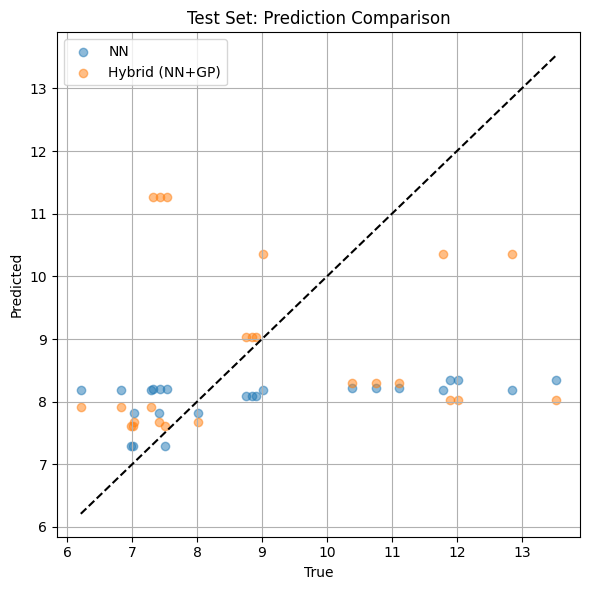

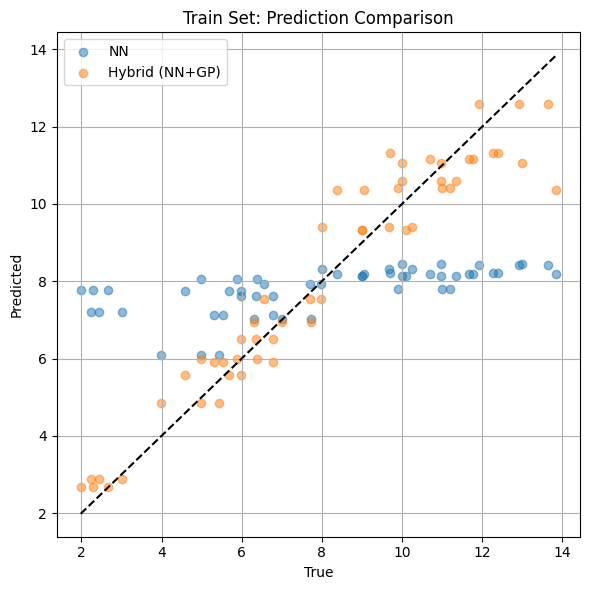

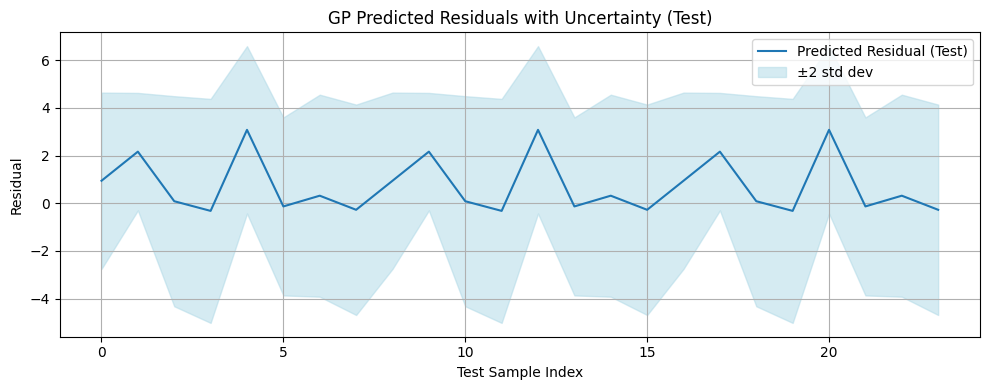

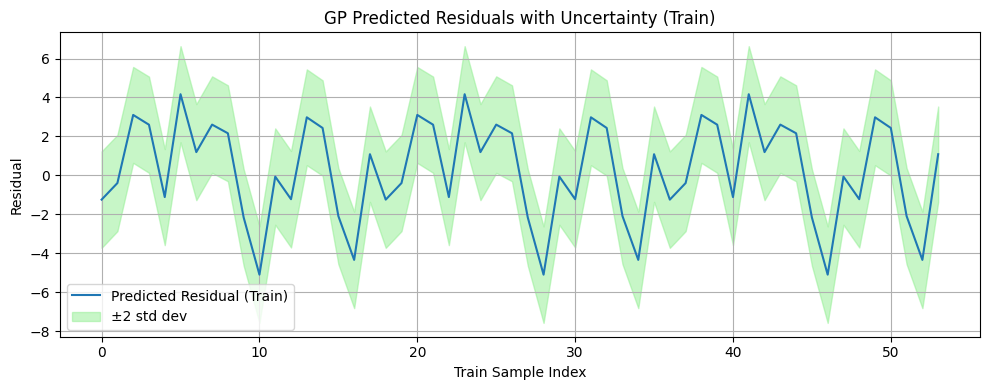

In [23]:
# Required libraries
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Use best-trained NN model
net.eval()

# === Get NN predictions on train/test sets (original scale)
with torch.no_grad():
    y_train_pred_nn_scaled = net(X_train_nn).numpy()
    y_test_pred_nn_scaled = net(X_test_nn).numpy()

y_train_pred_nn = scaler_y.inverse_transform(y_train_pred_nn_scaled)
y_test_pred_nn = scaler_y.inverse_transform(y_test_pred_nn_scaled)
y_train_true = scaler_y.inverse_transform(y_train_nn.numpy())
y_test_true = scaler_y.inverse_transform(y_test_nn.numpy())

# === Compute residuals (true - predicted)
residuals_train = y_train_true.ravel() - y_train_pred_nn.ravel()

# === Prepare inputs for GP (use scaled features)
X_gp_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_gp_train = torch.tensor(residuals_train, dtype=torch.float32)

# === Define Exact GP model
class ResidualGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        input_dim = train_x.shape[1]
        kernel = gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=input_dim)
        kernel.register_constraint("raw_lengthscale", gpytorch.constraints.Interval(1e-2, 10.0))
        self.covar_module = gpytorch.kernels.ScaleKernel(kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# === Initialize GP
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ResidualGPModel(X_gp_train, y_gp_train, likelihood)

# === Early stopping for GP
class GPEarlyStopping:
    def __init__(self, patience=15, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None
        self.best_likelihood_state = None

    def __call__(self, loss, model, likelihood):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            self.best_model_state = model.state_dict()
            self.best_likelihood_state = likelihood.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# === Train GP with early stopping
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
early_stopping = GPEarlyStopping(patience=15, min_delta=1e-4)

max_epochs = 200
for epoch in range(1, max_epochs + 1):
    optimizer.zero_grad()
    output = model(X_gp_train)
    loss = -mll(output, y_gp_train)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

    early_stopping(loss.item(), model, likelihood)
    if early_stopping.early_stop:
        print(f"\n🛑 Early stopping triggered at epoch {epoch}")
        break

# === Restore best model
if early_stopping.best_model_state is not None:
    model.load_state_dict(early_stopping.best_model_state)
    likelihood.load_state_dict(early_stopping.best_likelihood_state)
    print("✅ Restored best GP model based on early stopping.")

# === Predict residuals on test data
model.eval()
likelihood.eval()
# === Predict residuals on both train and test data
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_test = likelihood(model(X_gp_test))
    predicted_residuals_test = pred_test.mean.numpy()
    predicted_std_test = pred_test.stddev.numpy()

    pred_train = likelihood(model(X_gp_train))
    predicted_residuals_train = pred_train.mean.numpy()
    predicted_std_train = pred_train.stddev.numpy()

# === Hybrid predictions (NN + GP residual correction)
y_pred_hybrid_test = y_test_pred_nn.ravel() + predicted_residuals_test
y_pred_hybrid_train = y_train_pred_nn.ravel() + predicted_residuals_train

# === Evaluation (Test)
print("\n📊 Neural Network Only (Test):")
mae_nn_test = mean_absolute_error(y_test_true, y_test_pred_nn)
print(f"MAE: {mae_nn_test:.4f}")
print(f"MSE: {mean_squared_error(y_test_true, y_test_pred_nn):.4f}")
print(f"R²: {r2_score(y_test_true, y_test_pred_nn):.4f}")

print("\n🌲 Hybrid Model (NN + GP Residual) - Test:")
mae_hybrid_test = mean_absolute_error(y_test_true, y_pred_hybrid_test)
print(f"MAE: {mae_hybrid_test:.4f}")
print(f"MSE: {mean_squared_error(y_test_true, y_pred_hybrid_test):.4f}")
print(f"R²: {r2_score(y_test_true, y_pred_hybrid_test):.4f}")

# === Evaluation (Train)
print("\n📊 Neural Network Only (Train):")
mae_nn_train = mean_absolute_error(y_train_true, y_train_pred_nn)
print(f"MAE: {mae_nn_train:.4f}")
print(f"MSE: {mean_squared_error(y_train_true, y_train_pred_nn):.4f}")
print(f"R²: {r2_score(y_train_true, y_train_pred_nn):.4f}")

print("\n🌲 Hybrid Model (NN + GP Residual) - Train:")
mae_hybrid_train = mean_absolute_error(y_train_true, y_pred_hybrid_train)
print(f"MAE: {mae_hybrid_train:.4f}")
print(f"MSE: {mean_squared_error(y_train_true, y_pred_hybrid_train):.4f}")
print(f"R²: {r2_score(y_train_true, y_pred_hybrid_train):.4f}")

# === Plot: Predicted vs Actual (Test)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_true, y_test_pred_nn, label="NN", alpha=0.5)
plt.scatter(y_test_true, y_pred_hybrid_test, label="Hybrid (NN+GP)", alpha=0.5)
plt.plot([y_test_true.min(), y_test_true.max()],
         [y_test_true.min(), y_test_true.max()], 'k--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Test Set: Prediction Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot: Predicted vs Actual (Train)
plt.figure(figsize=(6, 6))
plt.scatter(y_train_true, y_train_pred_nn, label="NN", alpha=0.5)
plt.scatter(y_train_true, y_pred_hybrid_train, label="Hybrid (NN+GP)", alpha=0.5)
plt.plot([y_train_true.min(), y_train_true.max()],
         [y_train_true.min(), y_train_true.max()], 'k--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Train Set: Prediction Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot: GP Uncertainty (Test)
plt.figure(figsize=(10, 4))
plt.plot(predicted_residuals_test, label="Predicted Residual (Test)")
plt.fill_between(np.arange(len(predicted_residuals_test)),
                 predicted_residuals_test - 2 * predicted_std_test,
                 predicted_residuals_test + 2 * predicted_std_test,
                 color='lightblue', alpha=0.5, label="±2 std dev")
plt.title("GP Predicted Residuals with Uncertainty (Test)")
plt.xlabel("Test Sample Index")
plt.ylabel("Residual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot: GP Uncertainty (Train)
plt.figure(figsize=(10, 4))
plt.plot(predicted_residuals_train, label="Predicted Residual (Train)")
plt.fill_between(np.arange(len(predicted_residuals_train)),
                 predicted_residuals_train - 2 * predicted_std_train,
                 predicted_residuals_train + 2 * predicted_std_train,
                 color='lightgreen', alpha=0.5, label="±2 std dev")
plt.title("GP Predicted Residuals with Uncertainty (Train)")
plt.xlabel("Train Sample Index")
plt.ylabel("Residual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


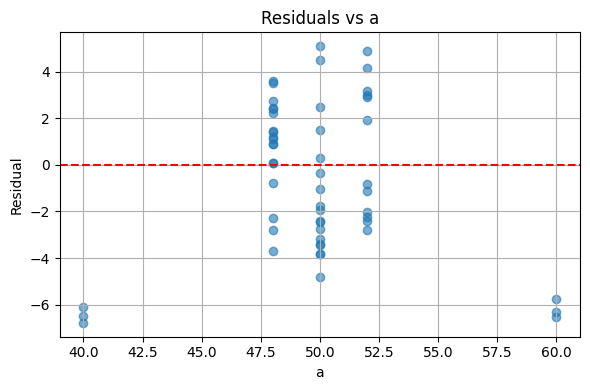

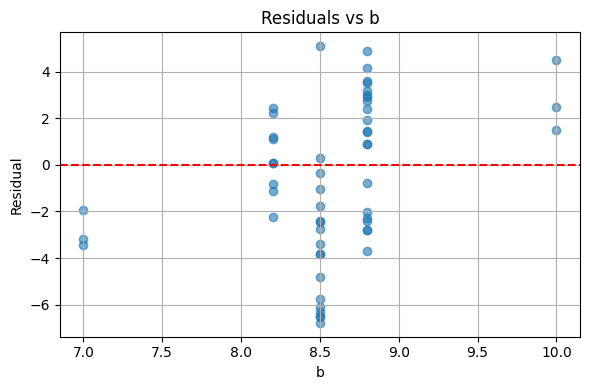

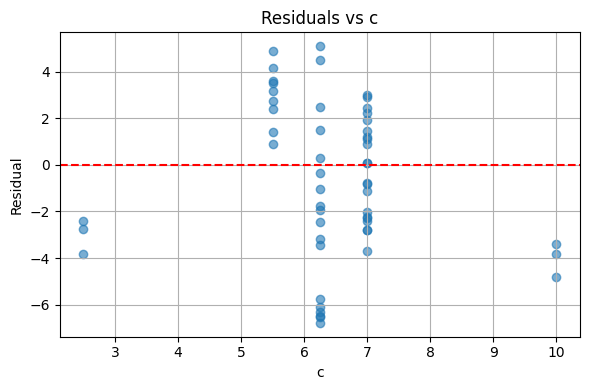

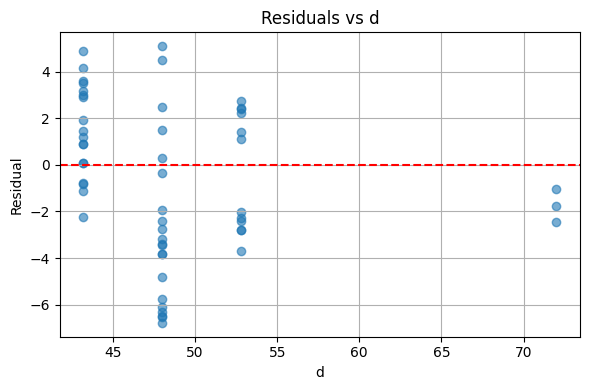

Residual Correlations with Inputs:
 a   -0.019805
b    0.348028
c   -0.119132
d   -0.209076
Name: residual, dtype: float64


In [21]:
import matplotlib.pyplot as plt

feature_names = ['a', 'b', 'c', 'd']
residuals_train = y_train_true.ravel() - y_train_pred_nn.ravel()

for i, name in enumerate(feature_names):
    plt.figure(figsize=(6, 4))
    plt.scatter(X_train_raw[:, i], residuals_train, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residuals vs {name}")
    plt.xlabel(name)
    plt.ylabel("Residual")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

import pandas as pd

df = pd.DataFrame(X_train_raw, columns=feature_names)
df['residual'] = residuals_train

correlations = df.corr()['residual'].drop('residual')
print("Residual Correlations with Inputs:\n", correlations)




In [16]:
import pandas as pd
import numpy as np

# Assuming X_train_raw is a NumPy array or DataFrame with columns ['a', 'b', 'c', 'd']
# Convert to DataFrame if needed
if not isinstance(X_train_raw, pd.DataFrame):
    X_train_df = pd.DataFrame(X_train_raw, columns=['a', 'b', 'c', 'd'])
else:
    X_train_df = X_train_raw.copy()

# Compute pairwise interaction terms
interaction_terms = {}
features = X_train_df.columns
for i in range(len(features)):
    for j in range(i+1, len(features)):
        name = f"{features[i]}*{features[j]}"
        interaction_terms[name] = X_train_df[features[i]] * X_train_df[features[j]]

# Combine interaction terms into DataFrame
interaction_df = pd.DataFrame(interaction_terms)

# Compute correlations with residuals
corr_interactions = interaction_df.apply(lambda x: np.corrcoef(x, residuals_train)[0,1])

print("Residual Correlations with Interaction Terms:")
print(corr_interactions)


Residual Correlations with Interaction Terms:
a*b    0.052963
a*c   -0.028072
a*d   -0.036798
b*c   -0.014057
b*d   -0.014039
c*d   -0.051700
dtype: float64
